In [ ]:
!pip install mat73
# !pip install git+https://github.com/nickkunz/smogn.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import smogn
import random as rn
from scipy.io import loadmat
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import mat73
from numpy.random import seed
import os

seed = 40
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
data = mat73.loadmat('X_train_python_features_collection.mat')
type(data)

dict

In [ ]:
data.keys()

dict_keys(['X_train_python_features_collection'])

In [ ]:
type(data['X_train_python_features_collection']), data['X_train_python_features_collection'].shape

(numpy.ndarray, (240, 5, 30, 5))

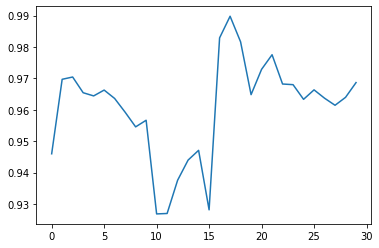

In [ ]:
X_features = data['X_train_python_features_collection']
plt.plot(X_features[239,2,:,4])
plt.show()

In [ ]:
y = pd.read_csv('In718 Sample Information.csv') 
y = y['Max Pore Area'].to_numpy()
y = y.reshape(240,1)
y.shape

(240, 1)

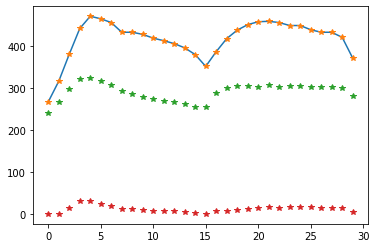

(240, 5, 30, 3)

In [ ]:
X_features_trimmed = X_features[:,:,:,[0,1,2]]
plt.plot(X_features[239,2,:,0])
plt.plot(X_features_trimmed[239,2,:],'*')
plt.show()
X_features_trimmed.shape

In [ ]:
data2 = mat73.loadmat('X_train_python_features_collection_4Folds.mat')
classes = data2['class']

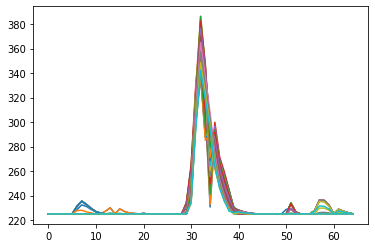

In [ ]:
data3 = mat73.loadmat('X_train_python_collection.mat')
X_profiles = data3['X_train_python_collection']
plt.plot(X_profiles[5,2,:,:].T)
plt.show()

# Helper Functions

In [ ]:
def prediction_results(cnn,X_test,y_test,X_train,y_train):
  test_predictions = cnn.predict(X_test)
  train_predictions = cnn.predict(X_train)

  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('For Test data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
  predictionError = y_train - train_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_train)-np.min(y_train))
  rmse_wrt_mean = rmse/np.mean(y_train)

  print('\nFor Train data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_train)-np.min(y_train),rmse_wrt_range,np.mean(y_train),rmse_wrt_mean))

  data_max = max(np.max(test_predictions), np.max(y_test),np.max(train_predictions), np.max(y_train))
  plt.plot(train_predictions,y_train,'b.')
  plt.plot(test_predictions,y_test,'r.')
  plt.legend(['test','train'])
  plt.plot([0,data_max],[0,data_max])
  plt.show()

def training_history_with_validation(training):
  plt.plot(training.history['loss'])
  plt.plot(training.history['val_loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.plot(training.history['val_root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train','dev'])
  plt.show()

def training_history(training):
  plt.plot(training.history['loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train'])
  plt.show()

def accuracy_measure(predictions, true_value, percentage):
  scores = []
  for p,t in zip(predictions,true_value):
    if abs(p-t) < t*percentage:
      scores.append(1)
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))

def combined_prediction_results(test_predictions,y_test):
  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('RMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
def combined_predictions_4Folds(X,Classifier_model,Q1_model,Q2_model,Q3_model,Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1_test_predictions = Q1_model.predict(X)
  Q2_test_predictions = Q2_model.predict(X)
  Q3_test_predictions = Q3_model.predict(X)
  Q4_test_predictions = Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1_test_predictions,Q2_test_predictions,Q3_test_predictions,Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

def combined_predictions_2Folds(X,Classifier_model,Q1Q2_model,Q3Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1Q2_test_predictions = Q1Q2_model.predict(X)
  Q3Q4_test_predictions = Q3Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1Q2_test_predictions,Q3Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

# Single Model -VS- Combined Models

In [ ]:
from tensorflow.keras.models import load_model
FeatureRegressionModel = load_model('MSE596ACNN_ThermalFeatures_V5.h5')
# ProfileRegressionModel = load_model('MSE596ACNN_V6.h5')
# # FeatureRegressionModel = cnn
# Classifier_model_perfect = load_model('MSE596ACNN_4folds_Classifier_ALL.h5')
# Classifier_model_2Folds = load_model('MSE596ACNN_2folds_Classifier.h5')
# Classifier_model_4Folds = load_model('MSE596ACNN_4folds_Classifier.h5')
# Q1_model = load_model('MSE596ACNN_Feature_Q1.h5')
# Q2_model = load_model('MSE596ACNN_Feature_Q2.h5')
# Q3_model = load_model('MSE596ACNN_Feature_Q3.h5')
# Q4_model = load_model('MSE596ACNN_Feature_Q4.h5')
# Q1Q2_model = load_model('MSE596ACNN_Feature_Q1Q2.h5')
# Q3Q4_model = load_model('MSE596ACNN_Feature_Q3Q4.h5')

# Check Accuracy

In [ ]:
percentage = 0.1
print('Predictions for ALL data:')
print('\nFeatureRegressionModel performance')
accuracy_measure(FeatureRegressionModel.predict(X_features_trimmed),y,percentage)

print('\nProfileRegressionModel performance')
accuracy_measure(ProfileRegressionModel.predict(X_profiles),y,percentage)

print('\n4-Folds FeatureRegressionModel performance')
combined_test_predictions1, combined_test_predictions2 = \
combined_predictions_4Folds(X_features_trimmed,Classifier_model_4Folds,Q1_model,Q2_model,Q3_model,Q4_model)
accuracy_measure(combined_test_predictions1,y,percentage)
accuracy_measure(combined_test_predictions2,y,percentage)

print('\n2-Folds FeatureRegressionModel performance')
combined_test_predictions3, combined_test_predictions4 = \
combined_predictions_2Folds(X_features_trimmed,Classifier_model_2Folds,Q1Q2_model,Q3Q4_model)
accuracy_measure(combined_test_predictions3,y,percentage)
accuracy_measure(combined_test_predictions4,y,percentage)

Predictions for ALL data:

FeatureRegressionModel performance
8/8 [==============================] - 0s 17ms/step
Accuracy: 60.83% out of 240 items

ProfileRegressionModel performance
8/8 [==============================] - 0s 22ms/step
Accuracy: 41.67% out of 240 items

4-Folds FeatureRegressionModel performance
8/8 [==============================] - 0s 17ms/step
Accuracy: 63.75% out of 240 items
Accuracy: 70.83% out of 240 items

2-Folds FeatureRegressionModel performance
8/8 [==============================] - 0s 18ms/step
Accuracy: 34.17% out of 240 items
Accuracy: 39.58% out of 240 items


# View accuracy with classes for wrong predictions

8/8 [==============================] - 1s 61ms/step
Accuracy: 40.0% out of 240 items


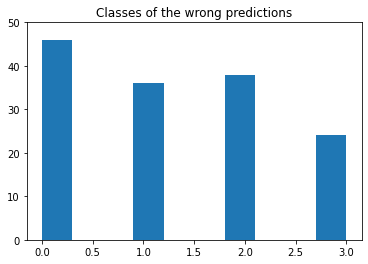



8/8 [==============================] - 0s 39ms/step
Accuracy: 79.17% out of 240 items


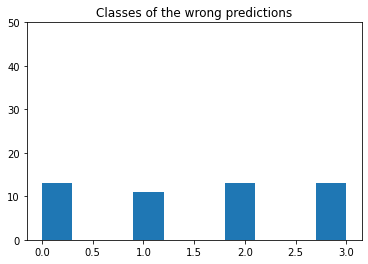



8/8 [==============================] - 0s 44ms/step
Accuracy: 39.58% out of 240 items


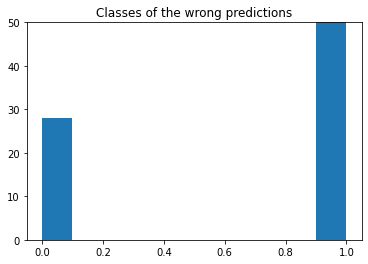

In [ ]:
def accuracy_measure_with_4CombinedModels(X, y,Classifier_model,Q1_model,Q2_model,Q3_model,Q4_model,percentage):
  y_pred = Classifier_model.predict(X)
  predicted_class = [np.argmax(element) for element in y_pred]
  Q1_test_predictions = Q1_model.predict(X)
  Q2_test_predictions = Q2_model.predict(X)
  Q3_test_predictions = Q3_model.predict(X)
  Q4_test_predictions = Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1_test_predictions,Q2_test_predictions,Q3_test_predictions,Q4_test_predictions), axis = 1)
  # predictions = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  predictions = np.sum(np.multiply(Q_test_predictions,np.round(y_pred,0)), axis = 1)
  scores = []
  wrong_classes = []
  for i in range(len(y)):
    p = predictions[i]
    t = y[i]
    if abs(p-t) < t*percentage:
      scores.append(1)
    else:
      wrong_classes.append(predicted_class[i])
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))
  plt.hist(wrong_classes)
  plt.ylim([0,50])
  plt.title('Classes of the wrong predictions')
  plt.show()

def accuracy_measure_with_2CombinedModels(X, y,Classifier_model,Q1Q2_model,Q3Q4_model,percentage):
  y_pred = Classifier_model.predict(X)
  predicted_class = [np.argmax(element) for element in y_pred]
  Q1Q2_test_predictions = Q1Q2_model.predict(X)
  Q3Q4_test_predictions = Q3Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1Q2_test_predictions,Q3Q4_test_predictions), axis = 1)
  # predictions = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  predictions = np.sum(np.multiply(Q_test_predictions,np.round(y_pred,0)), axis = 1)
  scores = []
  wrong_classes = []
  for i in range(len(y)):
    p = predictions[i]
    t = y[i]
    if abs(p-t) < t*percentage:
      scores.append(1)
    else:
      wrong_classes.append(predicted_class[i])
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))
  plt.hist(wrong_classes)
  plt.ylim([0,50])
  plt.title('Classes of the wrong predictions')
  plt.show()

def accuracy_measure_with_SingleModel(X, y,Classifier_model,regression_model,percentage):
  y_pred = Classifier_model.predict(X)
  predicted_class = [np.argmax(element) for element in y_pred]
  predictions = regression_model.predict(X)
  scores = []
  wrong_classes = []
  for i in range(len(y)):
    p = predictions[i]
    t = y[i]
    if abs(p-t) < t*percentage:
      scores.append(1)
    else:
      wrong_classes.append(predicted_class[i])
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))
  plt.hist(wrong_classes)
  plt.ylim([0,50])
  plt.title('Classes of the wrong predictions')
  plt.show()

accuracy_measure_with_SingleModel(X_features_trimmed, y, Classifier_model_perfect,FeatureRegressionModel,0.1)
print('\n')
accuracy_measure_with_4CombinedModels(X_features_trimmed, y, Classifier_model_perfect,Q1_model,Q2_model,Q3_model,Q4_model,0.1)
print('\n')
accuracy_measure_with_2CombinedModels(X_features_trimmed, y, Classifier_model_2Folds,Q1Q2_model,Q3Q4_model,0.1)

# Redundant Cells

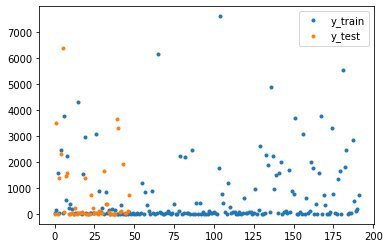

In [ ]:
r = 42
X_train, X_test, classes_train, classes_test = train_test_split(X_features_trimmed, classes, test_size=0.2, random_state=r, stratify=classes)
X_train, X_test, y_train, y_test = train_test_split(X_features_trimmed, y, test_size=0.2, random_state=r, stratify=classes)
plt.plot(y_train,'.')
plt.plot(y_test,'.')
plt.legend(['y_train','y_test'])
plt.show()

In [ ]:
y_test_pred = Classifier_model_4Folds.predict(X_test)
Q1_test_predictions = Q1_model.predict(X_test)
Q2_test_predictions = Q2_model.predict(X_test)
Q3_test_predictions = Q3_model.predict(X_test)
Q4_test_predictions = Q4_model.predict(X_test)
Q_test_predictions = np.concatenate((Q1_test_predictions,Q2_test_predictions,Q3_test_predictions,Q4_test_predictions), axis = 1)
combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

y_train_pred = Classifier_model_4Folds.predict(X_train)
Q1_train_predictions = Q1_model.predict(X_train)
Q2_train_predictions = Q2_model.predict(X_train)
Q3_train_predictions = Q3_model.predict(X_train)
Q4_train_predictions = Q4_model.predict(X_train)
Q_train_predictions = np.concatenate((Q1_train_predictions,Q2_train_predictions,Q3_train_predictions,Q4_train_predictions), axis = 1)
combined_train_predictions1 = np.sum(np.multiply(Q_train_predictions,y_train_pred), axis = 1)
combined_train_predictions2 = np.sum(np.multiply(Q_train_predictions,np.round(y_train_pred,0)), axis = 1)

# data_max = max(np.max(combined_test_predictions1), np.max(classes_test),np.max(combined_train_predictions1), np.max(classes_train))
# # data_max = max(np.max(Combined_test_predictions), np.max(classes_test))
# plt.plot(combined_train_predictions1,y_train,'b.')
# plt.plot(combined_test_predictions1,y_test,'r.')
# plt.plot([0,data_max],[0,data_max])
# plt.show()
# plt.figure()
# plt.plot(combined_train_predictions2,y_train,'b.')
# plt.plot(combined_test_predictions2,y_test,'r.')
# # plt.legend(['test','train'])
# plt.plot([0,data_max],[0,data_max])
# plt.show()
# combined_prediction_results(combined_test_predictions1,y_test)
# print('\n')
# combined_prediction_results(combined_train_predictions1,y_train)
# print('\n')
# combined_prediction_results(combined_test_predictions2,y_test)
# print('\n')
# combined_prediction_results(combined_train_predictions2,y_train)

6/6 [==============================] - 0s 30ms/step


In [ ]:
# FeatureRegressionModel = load_model('MSE596ACNN_ThermalFeatures_V2.h5')
percentage = 0.1
print('For testing data:')
accuracy_measure(FeatureRegressionModel.predict(X_test),y_test,percentage), 
accuracy_measure(combined_test_predictions1,y_test,percentage), 
accuracy_measure(combined_test_predictions2,y_test,percentage), 
print('\nFor training data:')
accuracy_measure(FeatureRegressionModel.predict(X_train),y_train,percentage), 
accuracy_measure(combined_train_predictions1,y_train,percentage), 
accuracy_measure(combined_train_predictions2,y_train,percentage)

For testing data:
2/2 [==============================] - 0s 30ms/step
Accuracy: 8.33% out of 48 items
Accuracy: 25.0% out of 48 items
Accuracy: 39.58% out of 48 items

For training data:
6/6 [==============================] - 0s 54ms/step
Accuracy: 47.92% out of 192 items
Accuracy: 73.44% out of 192 items
Accuracy: 78.65% out of 192 items
